In [1]:
import os
import math
import pandas as pd
import numpy as np
from tqdm.notebook import tqdm
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.utils.class_weight import compute_sample_weight
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
data = pd.read_csv('data/full_data.csv', parse_dates=['date'])

stations = ['SGP', 'EGB', 'AMA', 'SAO', 'HRW', 'VIE', 'BSL', 'WAL', 'POV', 'MLP', 'ABZ',
            'ABZ', 'NEU', 'VHL', 'KCE', 'ASP', 'KPZ', 'PRL', 'HYY', 'HEL', 'VAR', 'BOT',
            'MAR', 'AMM', 'HAD', 'UAE', 'DEL', 'MUK', 'ZOT', 'BEI', 'NAN']

# filter
data = data[data.station.isin(stations)]
data = data[data.n100 >= 1]

data['weight'] = compute_sample_weight(class_weight='balanced', y=data.station)

aerosols = ['aermr01', 'aermr02', 'aermr03', 'aermr04', 'aermr05', 'aermr06', 
            'aermr07', 'aermr08', 'aermr09', 'aermr10', 'aermr11']

gases = ['co', 'c5h8', 'c10h16', 'nh3', 'no', 'no2', 'so2']

met = ['d2m', 't2m', 'blh', 'rh', 'wind_speed', 'crwc']
        
loc = ['latitude', 'longitude']

log_transform = ['n100'] + aerosols + gases + ['crwc']

# log-transforming the selected variables, setting negative values to the minimum observed positive value
for v in log_transform:
    data[v] = np.log(data[v].where(data[v] > 0, data[v][data[v] > 0].min()))    
    
data.head()

,id,station,date,latitude,longitude,n100,aermr01,aermr02,aermr03,aermr04,...,no,no2,so2,d2m,t2m,crwc,blh,rh,wind_speed,weight
0,ABZ-2012-01-26 18:00:00,ABZ,2012-01-26 18:00:00,50.57,12.99,8.004610,-25.205400,-20.758221,-23.644620,-32.349837,...,-20.375236,-17.606319,-19.048942,265.94745,268.02210,-23.343861,341.34552,85.351851,2.343428,1.144657
1,ABZ-2012-01-26 21:00:00,ABZ,2012-01-26 21:00:00,50.57,12.99,7.930467,-25.128177,-20.680886,-23.922713,-33.939763,...,-19.560968,-17.517805,-18.690249,264.51917,266.25134,-23.343861,256.22314,87.455067,2.290729,1.144657
2,ABZ-2012-01-27 00:00:00,ABZ,2012-01-27 00:00:00,50.57,12.99,7.648740,-25.586803,-21.139579,-24.793668,-30.044488,...,-18.490878,-17.415018,-18.248112,264.04578,265.29468,-23.343861,172.99615,90.734149,1.933842,1.144657
3,ABZ-2012-01-27 03:00:00,ABZ,2012-01-27 03:00:00,50.57,12.99,7.493512,-26.083640,-21.636795,-25.519402,-28.561505,...,-17.796891,-17.333992,-18.250056,263.76500,265.05933,-23.343861,147.33954,90.393698,1.588926,1.144657
4,ABZ-2012-01-27 06:00:00,ABZ,2012-01-27 06:00:00,50.57,12.99,7.599552,-26.317107,-21.870332,-26.070951,-27.517164,...,-17.289473,-17.435466,-18.717292,264.02032,265.33960,-23.343861,112.06348,90.239081,1.724053,1.144657


In [3]:
feature_list = gases + met + aerosols + loc

In [5]:
# Compute the difference between consecutive rows
differences = data['n100'].diff()

# Filter out rows where the difference is zero
data = data[differences != 0]

In [6]:
# calculate time difference between consecutive rows
time_diff = data.groupby('station')['date'].diff()

# find rows where time difference is greater than 3 hours
gap_rows = time_diff > pd.Timedelta('3 hours')

# create a new segment every time a gap is detected
segment_ids = gap_rows.groupby(data['station']).cumsum()

# create group_ids column by concatenating station name and segment_ids
data['group_ids'] = data['station'] + '_segment_' + segment_ids.astype(str)

# group by station and group_ids, and assign a unique index to each row within each group
data['time_idx'] = data.groupby(['station', 'group_ids']).cumcount()

/tmp/dholmber/17907321/ipykernel_2742999/1462316713.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['group_ids'] = data['station'] + '_segment_' + segment_ids.astype(str)
/tmp/dholmber/17907321/ipykernel_2742999/1462316713.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['time_idx'] = data.groupby(['station', 'group_ids']).cumcount()


In [7]:
data.head()

,id,station,date,latitude,longitude,n100,aermr01,aermr02,aermr03,aermr04,...,so2,d2m,t2m,crwc,blh,rh,wind_speed,weight,group_ids,time_idx
0,ABZ-2012-01-26 18:00:00,ABZ,2012-01-26 18:00:00,50.57,12.99,8.004610,-25.205400,-20.758221,-23.644620,-32.349837,...,-19.048942,265.94745,268.02210,-23.343861,341.34552,85.351851,2.343428,1.144657,ABZ_segment_0,0
1,ABZ-2012-01-26 21:00:00,ABZ,2012-01-26 21:00:00,50.57,12.99,7.930467,-25.128177,-20.680886,-23.922713,-33.939763,...,-18.690249,264.51917,266.25134,-23.343861,256.22314,87.455067,2.290729,1.144657,ABZ_segment_0,1
2,ABZ-2012-01-27 00:00:00,ABZ,2012-01-27 00:00:00,50.57,12.99,7.648740,-25.586803,-21.139579,-24.793668,-30.044488,...,-18.248112,264.04578,265.29468,-23.343861,172.99615,90.734149,1.933842,1.144657,ABZ_segment_0,2
3,ABZ-2012-01-27 03:00:00,ABZ,2012-01-27 03:00:00,50.57,12.99,7.493512,-26.083640,-21.636795,-25.519402,-28.561505,...,-18.250056,263.76500,265.05933,-23.343861,147.33954,90.393698,1.588926,1.144657,ABZ_segment_0,3
4,ABZ-2012-01-27 06:00:00,ABZ,2012-01-27 06:00:00,50.57,12.99,7.599552,-26.317107,-21.870332,-26.070951,-27.517164,...,-18.717292,264.02032,265.33960,-23.343861,112.06348,90.239081,1.724053,1.144657,ABZ_segment_0,4


In [8]:
data.station.nunique()

30

In [9]:
data.shape

(333585, 33)

In [10]:
data.groupby('station')['group_ids'].nunique()

station
ABZ    144
AMA     74
AMM     14
ASP     38
BEI     46
BOT     47
BSL     16
DEL     68
EGB     20
HAD     16
HEL     97
HRW     72
HYY     91
KCE    176
KPZ    171
MAR     39
MLP    108
MUK    347
NAN     56
NEU     33
POV    297
PRL     35
SAO     33
SGP    215
UAE     21
VAR    218
VHL     14
VIE     26
WAL     45
ZOT     20
Name: group_ids, dtype: int64

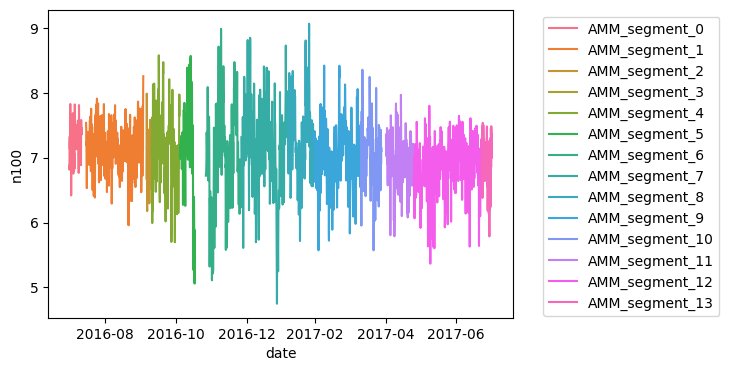

In [11]:
# Filter the data for station ZOT
filtered_data = data[data.station == 'AMM']

# Create the plot
plt.figure(figsize=(6, 4))
sns.lineplot(data=filtered_data, x='date', y='n100', hue='group_ids')

# Place the legend to the right of the plot
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

plt.show()

In [12]:
# group by station and group_ids, and calculate the length of each segment
segment_lengths = data.groupby(['station', 'group_ids']).size()

# calculate time difference between consecutive rows
time_diff = data.groupby('station')['date'].diff()

# filter for rows where time difference is greater than 3 hours
gap_lengths = time_diff[time_diff > pd.Timedelta('3 hours')]

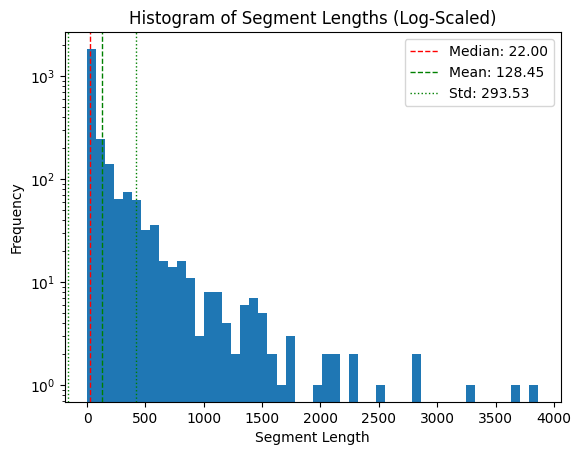

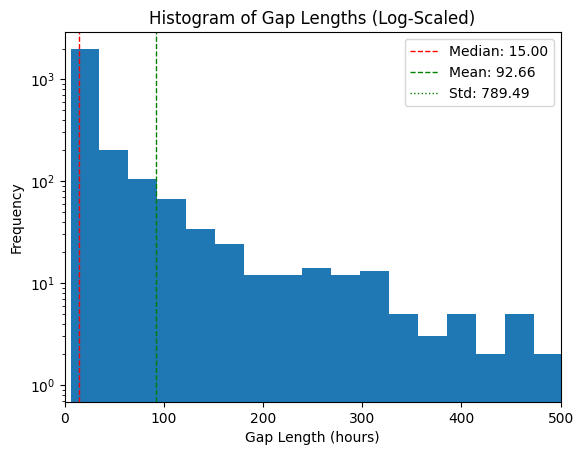

In [13]:
# calculate median, mean, and std for segment lengths
segment_median = np.median(segment_lengths)
segment_mean = np.mean(segment_lengths)
segment_std = np.std(segment_lengths)

# create histogram of segment lengths with median, mean, and std plotted
plt.hist(segment_lengths, bins=50, log=True)
plt.xlabel('Segment Length')
plt.ylabel('Frequency')
plt.title('Histogram of Segment Lengths (Log-Scaled)')
plt.axvline(segment_median, color='r', linestyle='dashed', linewidth=1)
plt.axvline(segment_mean, color='g', linestyle='dashed', linewidth=1)
plt.axvline(segment_mean + segment_std, color='g', linestyle='dotted', linewidth=1)
plt.axvline(segment_mean - segment_std, color='g', linestyle='dotted', linewidth=1)
plt.legend(['Median: {:.2f}'.format(segment_median), 'Mean: {:.2f}'.format(segment_mean), 'Std: {:.2f}'.format(segment_std)])
plt.show()

# calculate median, mean, and std for gap lengths
gap_median = np.median(gap_lengths / pd.Timedelta(hours=1))
gap_mean = np.mean(gap_lengths / pd.Timedelta(hours=1))
gap_std = np.std(gap_lengths / pd.Timedelta(hours=1))

# create histogram of gap lengths with median, mean, and std plotted
plt.hist(gap_lengths / pd.Timedelta(hours=1), bins=1000, log=True)
plt.xlabel('Gap Length (hours)')
plt.ylabel('Frequency')
plt.title('Histogram of Gap Lengths (Log-Scaled)')
plt.axvline(gap_median, color='r', linestyle='dashed', linewidth=1)
plt.axvline(gap_mean, color='g', linestyle='dashed', linewidth=1)
plt.axvline(gap_mean + gap_std, color='g', linestyle='dotted', linewidth=1)
plt.axvline(gap_mean - gap_std, color='g', linestyle='dotted', linewidth=1)
plt.legend(['Median: {:.2f}'.format(gap_median), 'Mean: {:.2f}'.format(gap_mean), 'Std: {:.2f}'.format(gap_std)])
plt.xlim([0, 500])
plt.show()

Text(0.5, 1.01, 'N100 concentrations for each station')

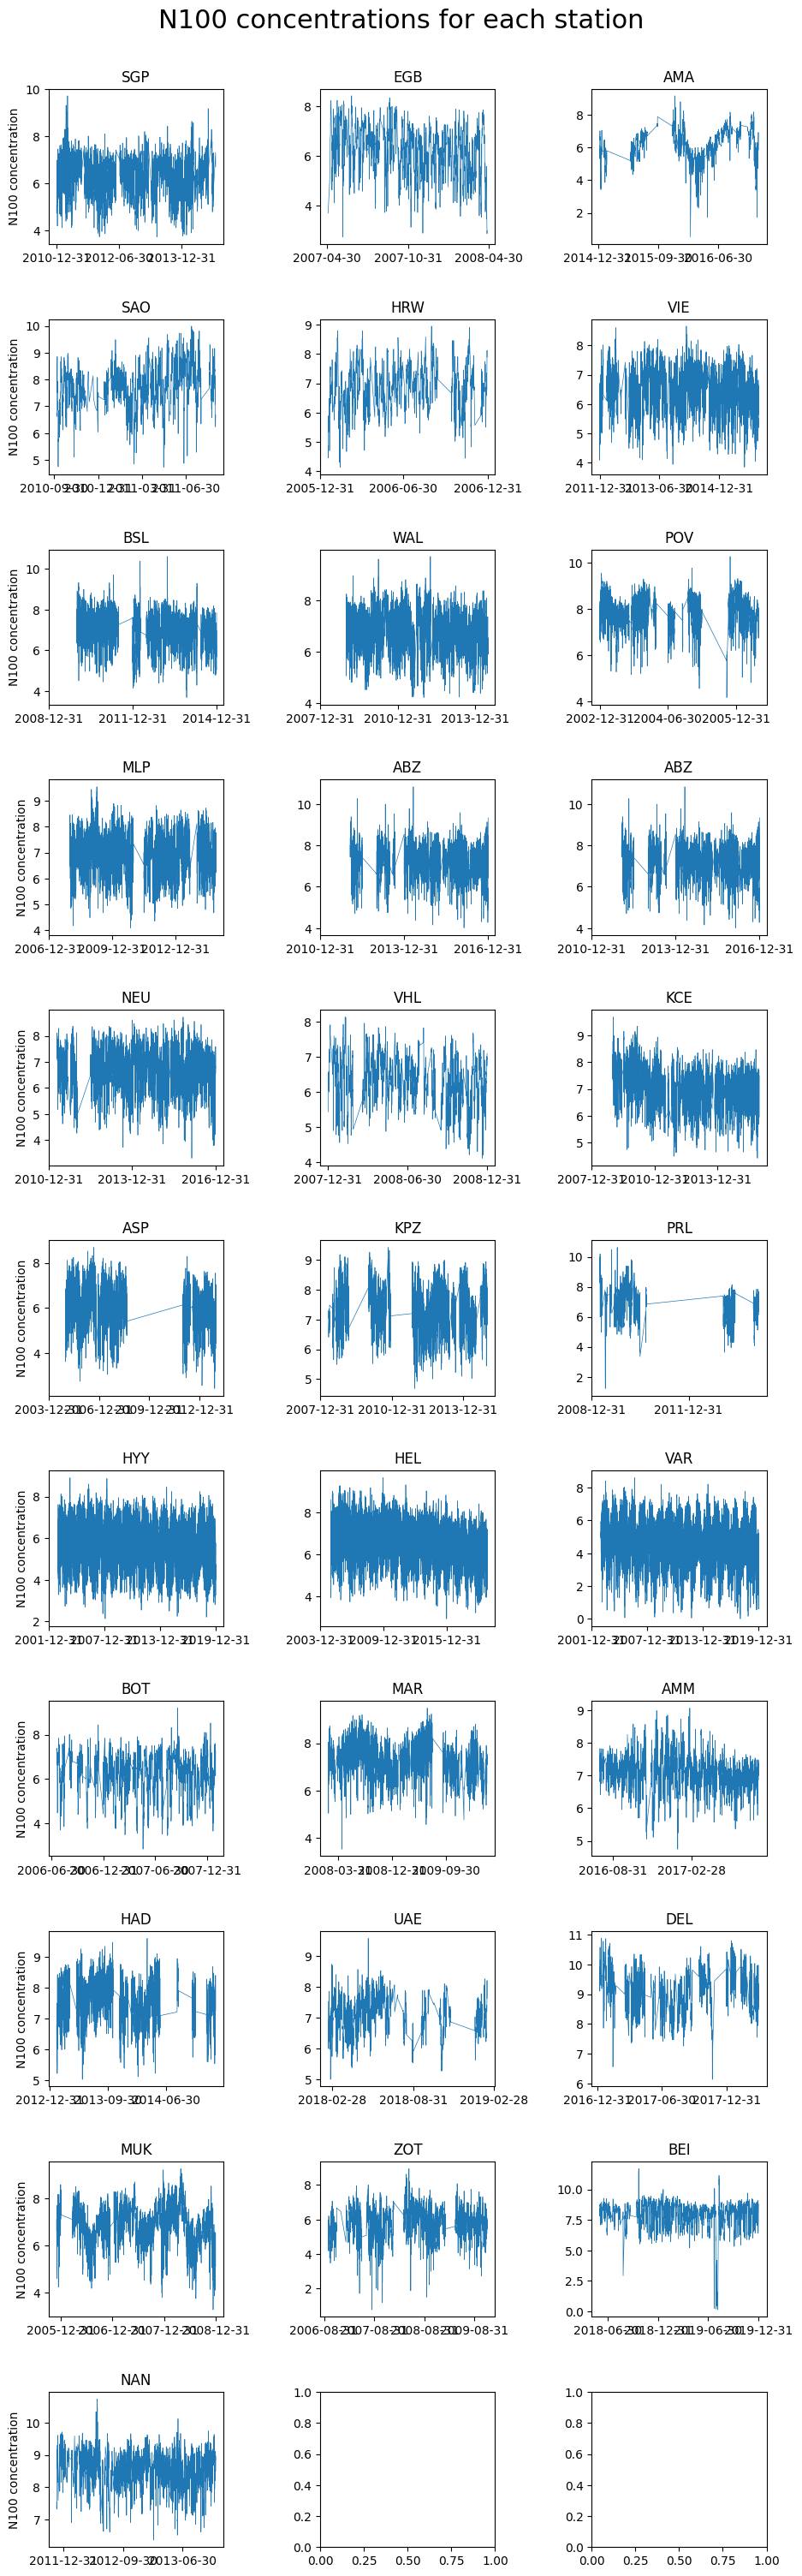

In [14]:
fig, axes = plt.subplots(11, 3, figsize=(10,30))
axes = iter(axes)
i = 0

for s in stations:
    if i%3 == 0:
        axis = next(axes)
    ax = axis[i%3]
    ax.plot(data.date.loc[data.station == s], data.n100.loc[data.station == s], lw=0.5)
    ax.set_title(s)
    ax.set_xticks(ax.get_xticks()[::3])
    if i%3 == 0:
        ax.set_ylabel('N100 concentration')
    i += 1
    
fig.tight_layout(pad=3)
fig.suptitle('N100 concentrations for each station', y=1.01, fontsize=22)

In [113]:
def create_gaps(s, gap_size):
    # Choose a random index to start the gap
    start = np.random.choice(range(len(s) - gap_size))
    # Create a boolean mask where the gap is represented by True
    mask = np.ones(len(s), dtype=bool)
    mask[start:start + gap_size] = False
    return mask

# Define the sequence length
sequence_length = 100

# Loop over each unique group
for group_id in tqdm(data.group_ids.unique(), desc='Processing groups'):
    group_data = data[data.group_ids == group_id]
    
    # Exclude groups shorter than sequence_length
    if len(group_data) < sequence_length:
        continue
    
    # Split the group data into sequences of length sequence_length
    num_full_splits = len(group_data) // sequence_length
    for split_index in range(num_full_splits):
        start = split_index * sequence_length
        end = start + sequence_length
        split_data = group_data.iloc[start:end].copy()
        
        # Create a gap with size randomly chosen between 1 and sequence_length
        # with exponentially decreasing frequency
        probs = np.geomspace(1, 0.01, sequence_length)
        probs /= probs.sum()
        gap_size = np.random.choice(range(1, sequence_length + 1), p=probs)
        split_data['mask'] = create_gaps(split_data['n100'], gap_size)
        
        # Save the split data to a CSV file
        split_data.to_csv(f"dataset/{group_id}_{split_index}.csv", index=False)
    
    # Handle the remaining part by including as many steps from the end as needed to make it sequence_length long
    start = num_full_splits * sequence_length
    remainder = len(group_data) - start
    if remainder > 0:
        # go back additional steps as needed to make it sequence_length long
        start = len(group_data) - sequence_length
        split_data = group_data.iloc[start:].copy()

        # Create a gap with size randomly chosen between 1 and the length of the remaining part
        # with exponentially decreasing frequency
        probs = np.geomspace(1, 0.01, len(split_data))
        probs /= probs.sum()
        gap_size = np.random.choice(range(1, len(split_data) + 1), p=probs)
        split_data['mask'] = create_gaps(split_data['n100'], gap_size)
        
        # Save the split data to a CSV file
        split_data.to_csv(f"dataset/{group_id}_{num_full_splits}.csv", index=False)

Processing groups:   0%|          | 0/2597 [00:00<?, ?it/s]

In [15]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn import TransformerEncoder, TransformerEncoderLayer
from torch.utils.data import Dataset, DataLoader, random_split
from torch.optim.lr_scheduler import LambdaLR
import pytorch_lightning as pl
from pytorch_lightning import Trainer

In [16]:
class GapFillingDataset(Dataset):
    def __init__(self, directory, feature_list):
        self.directory = directory
        self.filenames = os.listdir(directory)
        self.feature_list = feature_list
    
    def __len__(self):
        return len(self.filenames)
    
    def __getitem__(self, idx):
        filename = self.filenames[idx]
        filepath = os.path.join(self.directory, filename)
        data = pd.read_csv(filepath)

        # Extract the features and the target
        features = data[self.feature_list].values
        target = data['n100'].values
        mask = data['mask'].values
        
        # Convert to tensors
        features = torch.tensor(features, dtype=torch.float32)
        target = torch.tensor(target, dtype=torch.float32).unsqueeze(-1)
        mask = torch.tensor(mask, dtype=torch.bool).unsqueeze(-1)

        return features, target, mask

# Create the dataset
dataset = GapFillingDataset('dataset', feature_list)

In [17]:
# Split the dataset
generator = torch.Generator().manual_seed(42)
train_dataset, val_dataset, test_dataset = random_split(dataset, [0.8, 0.1, 0.1], generator=generator)

# Create the dataloaders
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=False)

**Positional encoding**

The original Transformer has a positional encoding with division by 10000 to the power of 2i/d in the formula to achieve different scales for each dimension in the positional encoding. This is beneficial because it allows the model to learn to attend to both near and far positions in the sequence.

The inclusion of 2π in the positional encoding makes it cyclical, with a period defined by the period parameter. This modification to the standard positional encoding is intended to capture the daily periodicity in the data.

The encoding can be described by eq.

$PE(p, 2i) = \sin\left(2 \pi \frac{p}{{10000}^{2i/d}}\right)$

and

$PE(p, 2i + 1) = \cos\left(2 \pi \frac{p}{{10000}^{2i/d}}\right)$

Ref. Attention is all you need. https://arxiv.org/pdf/1706.03762.pdf

In [18]:
def cyclic_positional_encoding(t, dim, period=8):
    assert dim % 2 == 0, "Dimension must be even."
    pos = torch.arange(t, dtype=torch.float).unsqueeze(1)
    div_term = torch.exp(torch.arange(0., dim, 2) * -(math.log(10000.0) / dim))
    pe = torch.zeros(t, dim)
    pe[:, 0::2] = torch.sin(2 * math.pi * pos / period * div_term)
    pe[:, 1::2] = torch.cos(2 * math.pi * pos / period * div_term)
    return pe

In [25]:
class TransformerModel(pl.LightningModule):
    def __init__(self, n_input, n_head, n_hidden, n_layers, n_output, learning_rate=0.1, seq_len=100, period=8):
        super().__init__()
        # Define embeddings
        self.feature_embedding = nn.Linear(n_input, n_hidden)
        self.target_embedding = nn.Linear(1, n_hidden)
        
        # Define positional encodings
        self.feature_positional_encoding = cyclic_positional_encoding(seq_len, n_hidden, period)
        self.target_positional_encoding = cyclic_positional_encoding(seq_len, n_hidden, period)
        
        self.feature_encoder_layer = TransformerEncoderLayer(d_model=n_hidden, nhead=n_head, dim_feedforward=n_hidden)
        self.feature_transformer_encoder = TransformerEncoder(self.feature_encoder_layer, num_layers=n_layers)
        
        self.target_encoder_layer = TransformerEncoderLayer(d_model=n_hidden, nhead=n_head, dim_feedforward=n_hidden)
        self.target_transformer_encoder = TransformerEncoder(self.target_encoder_layer, num_layers=n_layers)
        
        self.feed_forward = nn.Sequential(
            nn.Linear(n_hidden*2, 128),
            nn.GELU(),
            nn.Linear(128, 32)
        )
        self.gap_filler = nn.Linear(32, n_output)
        self.learning_rate = learning_rate
        

    def forward(self, features, target, mask):
        # Embedding inputs
        embedded_features = self.feature_embedding(features) + self.feature_positional_encoding.to(features.device)
        embedded_target = self.target_embedding(target) + self.target_positional_encoding.to(target.device)
        
        # Transformer Encoder
        output_features = self.feature_transformer_encoder(embedded_features)
        output_target = self.target_transformer_encoder(embedded_target)
        
        # Concatenate and Feed Forward
        output = torch.cat((output_features, output_target), dim=-1)
        output = self.feed_forward(output)
        output = self.gap_filler(output)
        
        # Masking and output
        output = output * ~mask
        output += target * mask
        return output

    def training_step(self, batch, batch_idx):
        features, targets, masks = batch
        outputs = self.forward(features, targets, masks)
        loss = F.mse_loss(outputs, targets)
        self.log('train_loss', loss)
        return loss

    def validation_step(self, batch, batch_idx):
        features, targets, masks = batch
        outputs = self.forward(features, targets, masks)
        loss = F.mse_loss(outputs, targets)
        self.log('val_loss', loss)

    def test_step(self, batch, batch_idx):
        features, targets, masks = batch
        outputs = self.forward(features, targets, masks)
        loss = F.mse_loss(outputs, targets)
        self.log('test_loss', loss)
    
    def lr_lambda(self, current_epoch):
        initial_lr = self.learning_rate
        max_epochs = self.trainer.max_epochs  # This gets the max number of epochs
        start_decay_epoch = int(max_epochs * 0.7)  # Start decay at 70% of max epochs

        if current_epoch < start_decay_epoch:
            return 1.0  # Keep the original learning rate
        else:
            # Compute the decay factor in the range [0, 1]
            decay_factor = (current_epoch - start_decay_epoch) / (max_epochs - start_decay_epoch)
            # Exponential decay down to 1% of the initial learning rate
            return (1.0 - 0.99 * decay_factor)
    
    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=0.0001)
        scheduler = LambdaLR(optimizer, self.lr_lambda)

        return {
            'optimizer': optimizer,
            'lr_scheduler': {
                'scheduler': scheduler,
                'interval': 'epoch',  # Update after each epoch
                'frequency': 1,  # How often to apply scheduler updates
            },
        }

In [26]:
# Initialize the model
n_input = len(feature_list)
n_head = 1
n_hidden = 64
n_layers = 2
n_output = 1 # 'n100'

model = TransformerModel(n_input, n_head, n_hidden, n_layers, n_output)

# Initialize a trainer
trainer = pl.Trainer(max_epochs=50, log_every_n_steps=1, logger=pl.loggers.TensorBoardLogger('logs/'))

# Train the model
trainer.fit(model, train_dataloader, val_dataloader)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name                        | Type                    | Params
------------------------------------------------------------------------
0 | feature_embedding           | Linear                  | 1.7 K 
1 | target_embedding            | Linear                  | 128   
2 | feature_encoder_layer       | TransformerEncoderLayer | 25.2 K
3 | feature_transformer_encoder | TransformerEncoder      | 50.4 K
4 | target_encoder_layer        | TransformerEncoderLayer | 25.2 K
5 | target_transformer_encoder  | TransformerEncoder      | 50.4 K
6 | feed_forward                | Sequential              | 20.6 K
7 | gap_filler                  | Linear                  | 33    
------------------------------------------------------------------------
173 K     Trainable params
0         Non-trainable params
173 K     Total params
0.695     Total estima

Sanity Checking: 0it [00:00, ?it/s]

/usr/local/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:430: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 40 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=50` reached.


In [28]:
# Test the model
trainer.test(dataloaders=train_dataloader)

Restoring states from the checkpoint path at logs/lightning_logs/version_11/checkpoints/epoch=49-step=4150.ckpt
Loaded model weights from the checkpoint at logs/lightning_logs/version_11/checkpoints/epoch=49-step=4150.ckpt


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_loss         │    0.01929585635662079    │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': 0.01929585635662079}]

In [29]:
# Test the model
trainer.test(dataloaders=val_dataloader)

Restoring states from the checkpoint path at logs/lightning_logs/version_11/checkpoints/epoch=49-step=4150.ckpt
Loaded model weights from the checkpoint at logs/lightning_logs/version_11/checkpoints/epoch=49-step=4150.ckpt


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_loss         │   0.018864255398511887    │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': 0.018864255398511887}]

In [30]:
# Test the model
trainer.test(dataloaders=test_dataloader)

Restoring states from the checkpoint path at logs/lightning_logs/version_11/checkpoints/epoch=49-step=4150.ckpt
Loaded model weights from the checkpoint at logs/lightning_logs/version_11/checkpoints/epoch=49-step=4150.ckpt


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_loss         │   0.024079522117972374    │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': 0.024079522117972374}]

In [31]:
trainer.save_checkpoint("model.ckpt")

In [32]:
model = TransformerModel.load_from_checkpoint(
    checkpoint_path="model.ckpt",
    n_input=n_input, 
    n_head=n_head, 
    n_hidden=n_hidden, 
    n_layers=n_layers, 
    n_output=n_output
)

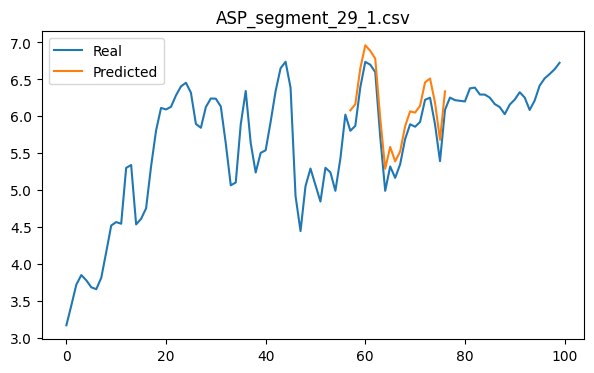

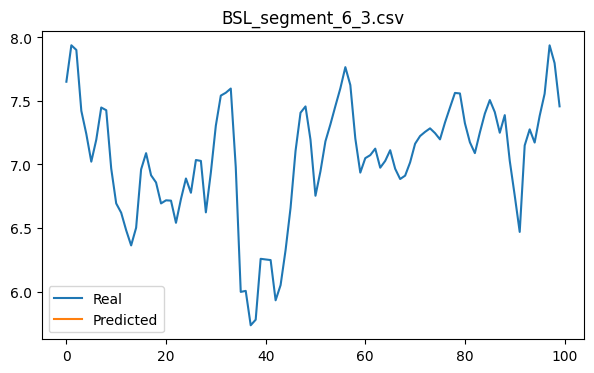

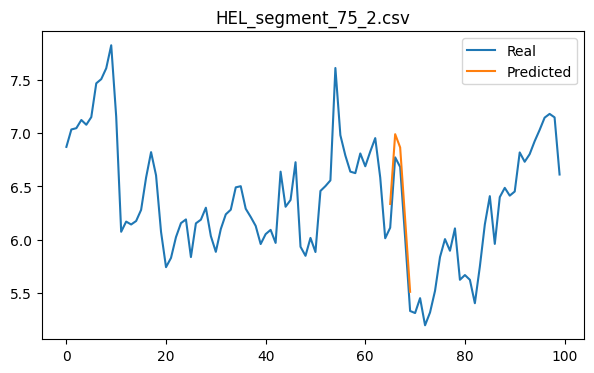

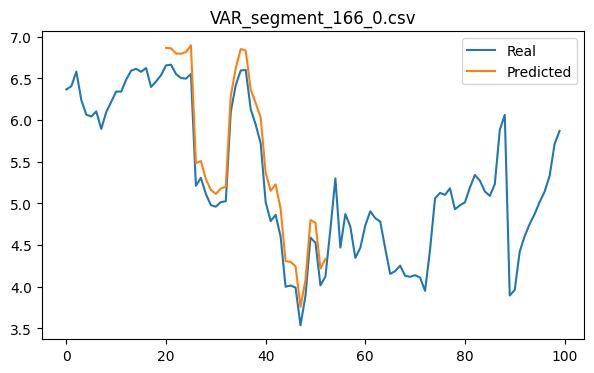

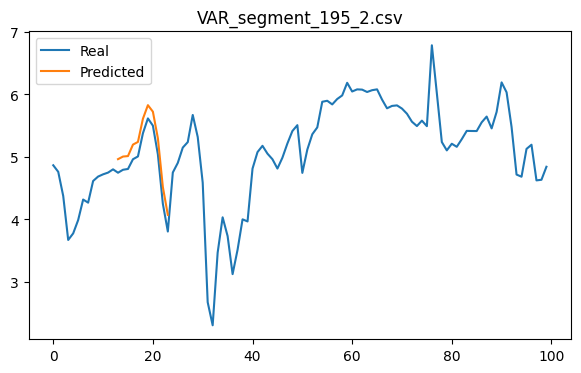

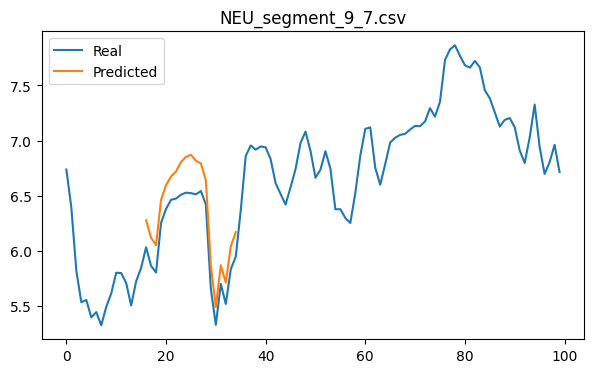

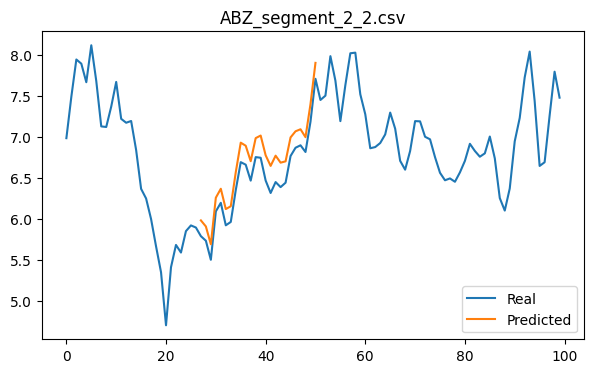

In [42]:
model.eval() # switch the model to evaluation mode

# Get a batch of data from the DataLoader
for batch in test_dataloader:
    sample = batch
    break

# get the model's prediction
with torch.no_grad():
    features, targets, mask = batch
    predictions = model(features, targets, mask)

# convert the tensors to numpy arrays for plotting
mask = mask.cpu().numpy()
targets = targets.cpu().numpy()
predictions = predictions.cpu().numpy()

for idx in range(0, 32, 5):

    # Get the indices where mask is zero
    indices = np.where(mask[idx] == False)

    plt.figure(figsize=(7, 4))
    plt.plot(targets[idx], label="Real")
    #plt.plot(predictions[idx], label="Complete")
    plt.plot(indices[0], predictions[idx][indices], label="Predicted")
    plt.title(dataset.filenames[test_dataset.indices[idx]])
    plt.legend()
    plt.show()